# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import calendar
import math
from datetime import date
from scipy.stats import linregress

# Import API keys
from api_keys import weather_api_key
from api_keys import g_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
success_lats = []
success_lngs = []
cities = []
city_names = []
countries = []
city_country = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=4500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=4500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]) #.city_name
    
    # If the city is unique, then add it to the cities list
    if city not in cities:
        cities.append(city)
        city_names.append(city.city_name)
        countries.append(city.country_code)
        success_lats.append(lat_lng[0])
        success_lngs.append(lat_lng[1])

# Print the city count to confirm sufficient count
print(f"The number randomly generated list of cities = {len(cities)}")
print(f"The number randomly generated list of city names = {len(city_names)}")
print(f"The number randomly generated list of countries = {len(countries)}")
print(f"The number randomly generated list of latitude coordinates = {len(success_lats)}")
print(f"The number randomly generated list of longitude coordinates = {len(success_lngs)}")
# print(f"The number randomly generated list of city-country names = {len(city_country)}")
print()
print(f"The number randomly generated list of unique countries = {len(list(set(countries)))}")

# print(success_lats)

The number randomly generated list of cities = 1338
The number randomly generated list of city names = 1338
The number randomly generated list of countries = 1338
The number randomly generated list of latitude coordinates = 1338
The number randomly generated list of longitude coordinates = 1338

The number randomly generated list of unique countries = 158


In [3]:
cities_data = {"City": city_names, "Country": countries, "Search Lats": success_lats, "Search Lngs": success_lngs}
cities_df = pd.DataFrame(cities_data)
cities_df["City-Country"] = cities_df[["City", "Country"]].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
cities_df = cities_df[["City-Country", "City", "Country", "Search Lats", "Search Lngs"]]

cities_df.head()

,City-Country,City,Country,Search Lats,Search Lngs
0,"ancud, cl",ancud,cl,-39.855717,-92.712901
1,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115
2,"dengzhou, cn",dengzhou,cn,37.868980,120.840363
3,"tilhar, in",tilhar,in,27.887681,79.616505
4,"thompson, ca",thompson,ca,66.428190,-98.290164


In [4]:
len(cities_df)

1338

### In the starter code example, 1,500 sets of randomly chosen latitude and longitude yielded 635 unique city names.  That means that 58% of randomly chosen latitude-longitude coordinates were duplicates and were rejected, if we read the documentation correctly.

### Since 2/3 of the surface area of the globe is water, there is a likelihood that 2/3 of the choices made by randomly selecting geocoordinates will be somewhere other than on land, which means that at least 2/3 of the cities selected by using random coordinates will be clustered on shorelines.  Bottom line, the real task is to randomly select geocoordinates only for the 1/3 of the planet surface that is land.

### Our solution is to reject any cities that are greater than 60 miles from the randomly chosen geocoordinates.  This requires me to measure the distance from the randomly chosen geocoordinates to the nearest city selected.  I may need to play with the method further to eyeball the best maximum distance.  With a highly iterative method, I could perhaps get maximum approximate equal distribution between cities to minimize any clustering tendencies. But I'm going to settle for an eyeball check on top of a pretty decent methodology.

### We note that this methodology might skew away from cities in more remote locations. 

In [5]:
# List of cities for which will will try to retrieve geocoordinates
cities_input = cities_df["City-Country"].tolist()

# ****NOTE IN LINE BELOW THAT head() IN FRONT OF .tolist() AFFECTS SIZE OF LISTS BUT IS USEFUL FOR TEST PURPOSES****
# cities_input = cities_df["City-Country"].head(30).tolist()

cities_input

['ancud, cl',
 'novyy urengoy, ru',
 'dengzhou, cn',
 'tilhar, in',
 'thompson, ca',
 'mayo, ca',
 'puerto ayora, ec',
 'bengkulu, id',
 'jamestown, sh',
 'cherskiy, ru',
 'coruripe, br',
 'hamilton, bm',
 'belmonte, br',
 'awjilah, ly',
 'camacha, pt',
 'albany, au',
 'lake havasu city, us',
 'uinskoye, ru',
 'kapaa, us',
 'salinas, ec',
 'bur gabo, so',
 'kiunga, pg',
 'rudnogorsk, ru',
 'dicabisagan, ph',
 'mataura, pf',
 'ushuaia, ar',
 'douglas, us',
 'yumen, cn',
 'yaan, cn',
 'noumea, nc',
 'rikitea, pf',
 'yellowknife, ca',
 'khamgaon, in',
 'barrow, us',
 'norman wells, ca',
 'georgetown, sh',
 'tabiauea, ki',
 'tasiilaq, gl',
 'sao joao da barra, br',
 'neryungri, ru',
 'kabalo, cd',
 'hericourt, fr',
 'gamba, ga',
 'quatre cocos, mu',
 'porto belo, br',
 'mar del plata, ar',
 'aginskoye, ru',
 'labuhan, id',
 'hobart, au',
 'victoria, sc',
 'punta arenas, cl',
 'nhulunbuy, au',
 'husavik, is',
 'manakara, mg',
 'severo-yeniseyskiy, ru',
 'busselton, au',
 'warqla, dz',
 'hil

### Perform Google API Calls for City Geocoordinates
* Gather geocoordinates for each city using a series of successive Google API calls.
* Include a print log of each city not found.


In [6]:
# Set empty lists to hold characters height and mass
target_cities = []
target_lats = []
target_lngs = []

# Loop through each character
for city1 in cities_input:
    
   # Try to extract latitude and longitude
    try:
        # Set url for API
        target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={city1}&key={g_key}'
        
        # Run a request to endpoint and convert result to json
        geo_data = requests.get(target_url).json()
        
        # Pause a few seconds to allow for processing delays
        time.sleep(1) 
        
        # Append returned latitude, longitude, and city
        target_lats.append(geo_data["results"][0]["geometry"]["location"]["lat"])
        target_lngs.append(geo_data["results"][0]["geometry"]["location"]["lng"])
        target_cities.append(city1) # THE ORDER OF THIS APPEND IS CRITICAL!!!
        
        # Printed as Check
        # print(f"{city1} found! Appending longitude and latitude")
        
    # Handle exceptions for cities whose geocoordiantes are not returned in the Google API
    except:
        # Append null values
        print(f"City {city1} not found")
        pass 

City lagunas, pe not found
City domna, ru not found
City sentyabrskiy, ru not found
City seymchan, ru not found
City faya, td not found
City genc, tr not found
City tambura, sd not found
City mitu, co not found
City artyk, ru not found
City mantua, cu not found
City komsomolskoye, ua not found
City zhoucheng, cn not found
City kachug, ru not found
City mana, gf not found
City naze, jp not found
City bargal, so not found
City karagaylinskiy, ru not found
City chulym, ru not found
City marabba, sd not found
City yefira, gr not found
City kongolo, cd not found


In [7]:
# Calculate number of cities for which lat-lng data successfully extracted
# And verify lists to be merged into dataframe are of same length
print(f"Original Input Cities = {len(cities_input)}")
print(f"Cities Not Found = {len(cities_input) - len(target_cities)}")
print()
print(f"Target Cities = {len(target_cities)}")
print(f"Target Latitutdes = {len(target_lats)}")
print(f"Target Longitudes = {len(target_lngs)}")

Original Input Cities = 1338
Cities Not Found = 21

Target Cities = 1317
Target Latitutdes = 1317
Target Longitudes = 1317


In [8]:
# Populate new dataframe with extracted with successfully extracted city-county, latitude and longitude data
cities_dict = {"City-Country": target_cities, "Actual Lats": target_lats, "Actual Lngs": target_lngs}
cities_df2 = pd.DataFrame(cities_dict)

cities_df2.head()

,City-Country,Actual Lats,Actual Lngs
0,"ancud, cl",-41.867500,-73.827697
1,"novyy urengoy, ru",66.095686,76.656352
2,"dengzhou, cn",32.687733,112.087455
3,"tilhar, in",27.961879,79.737094
4,"thompson, ca",38.239170,-122.280560


In [9]:
len(cities_df2)

1317

In [10]:
# Proof no duplicates were entered
cities_dedupe_df = cities_df.drop_duplicates(subset="City-Country")
cities_dedupe_df2 = cities_df2.drop_duplicates(subset="City-Country")

print(f"Number of records removed by deduplicaiton of Nearest City Search DF = {len(cities_df) - len(cities_dedupe_df)}")
print(f"Number of records removed by deduplicaiton of City Geocoordinates DF = {len(cities_df2) - len(cities_dedupe_df2)}")

Number of records removed by deduplicaiton of Nearest City Search DF = 1
Number of records removed by deduplicaiton of City Geocoordinates DF = 1


In [11]:
# Perform inner merge on the 2 dataframes
df1 = cities_df
df2 = cities_df2
df = pd.merge(df1, df2, on="City-Country")

# Alternative syntax
# df = df1.merge(df2, on="City-Country")

df.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs
0,"ancud, cl",ancud,cl,-39.855717,-92.712901,-41.867500,-73.827697
1,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115,66.095686,76.656352
2,"dengzhou, cn",dengzhou,cn,37.868980,120.840363,32.687733,112.087455
3,"tilhar, in",tilhar,in,27.887681,79.616505,27.961879,79.737094
4,"thompson, ca",thompson,ca,66.428190,-98.290164,38.239170,-122.280560


In [12]:
# Inner merge successful
len(df)

1319

In [13]:
df.dtypes

City-Country     object
City             object
Country          object
Search Lats     float64
Search Lngs     float64
Actual Lats     float64
Actual Lngs     float64
dtype: object

### Calculate distance using the trigonometric Haversine Formula
![Trigonometry Explanation](../Images/trig_1.jpg)

In [14]:
# Create a list to capture distance calculations
distance_list = []

# radius of the Earth, 3,958.8 mi (6373.0 km)
# presumably a blend of polar and equatorial radii
R = 3958.8

for index, row in df.iterrows():
    
    # coordinates - Used to search for Nearest City
    lat1 = math.radians(row["Search Lats"])
    lon1 = math.radians(row["Search Lngs"])
    
    # coordinates - Actual for City Selected
    lat2 = math.radians(row["Actual Lats"])
    lon2 = math.radians(row["Search Lngs"])
    
    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    
    distance_list.append(distance)

# print(distance_list)

In [15]:
# For convenience
df["Distance (mi)"] = distance_list
df.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs,Distance (mi)
0,"ancud, cl",ancud,cl,-39.855717,-92.712901,-41.867500,-73.827697,139.002327
1,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115,66.095686,76.656352,32.274692
2,"dengzhou, cn",dengzhou,cn,37.868980,120.840363,32.687733,112.087455,357.993602
3,"tilhar, in",tilhar,in,27.887681,79.616505,27.961879,79.737094,5.126657
4,"thompson, ca",thompson,ca,66.428190,-98.290164,38.239170,-122.280560,1947.694799


In [16]:
# Couunt the number of cities selected are in the combined data set
len(df)

1319

In [17]:
# Count the number of cities selected are within 60 miles
len(df.loc[df["Distance (mi)"] <= 60])

652

### The original search for the nearest city involved 1,500 random geocoordinates.  This yielded just over 200 cities that were less than or equal to 60 miles from the original random geocoordinates.  As a result, we # expanded our random geocoordinates set by a factor of 2x or higher to increase the odds of selecting at least 500 target cities that were within the maximum 60 mile search radius. So, we reran the next time with 3,500 random geocoordinates.

In [18]:
# Remove rows that have Distance values greater than 60
cities_60mi_df = df[~(df["Distance (mi)"] > 60)]
cities_60mi_df.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs,Distance (mi)
1,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115,66.095686,76.656352,32.274692
3,"tilhar, in",tilhar,in,27.887681,79.616505,27.961879,79.737094,5.126657
5,"mayo, ca",mayo,ca,64.080154,-132.471621,63.594262,-135.896492,33.572270
13,"awjilah, ly",awjilah,ly,29.639055,21.542582,29.090585,21.332197,37.896038
16,"lake havasu city, us",lake havasu city,us,34.247811,-114.375979,34.483901,-114.322455,16.312433


### Perform OpenWeatherMap API calls for each city
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [19]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

In [20]:
cities_60mi_list = cities_60mi_df["City-Country"].tolist()
cities_60mi_list

['novyy urengoy, ru',
 'tilhar, in',
 'mayo, ca',
 'awjilah, ly',
 'lake havasu city, us',
 'uinskoye, ru',
 'dicabisagan, ph',
 'yaan, cn',
 'khamgaon, in',
 'barrow, us',
 'neryungri, ru',
 'kabalo, cd',
 'hericourt, fr',
 'porto belo, br',
 'nhulunbuy, au',
 'husavik, is',
 'manakara, mg',
 'severo-yeniseyskiy, ru',
 'warqla, dz',
 'navabad, tj',
 'aboisso, ci',
 'healdsburg, us',
 'concordia, mx',
 'nueve de julio, ar',
 'talnakh, ru',
 'vaitupu, wf',
 'tahe, cn',
 'ondangwa, na',
 'olafsvik, is',
 'urengoy, ru',
 'cap-aux-meules, ca',
 'coquimbo, cl',
 'tinyahuarco, pe',
 'rujewa, tz',
 'lundazi, zm',
 'pemba, mz',
 'xuchang, cn',
 'urumqi, cn',
 'eyl, so',
 'kuche, cn',
 'bitung, id',
 'saint george, us',
 'tunduru, tz',
 'muravlenko, ru',
 'cozumel, mx',
 'luderitz, na',
 'maihar, in',
 'tomatlan, mx',
 'sandwick, gb',
 'shintomi, jp',
 'tunxi, cn',
 'pitimbu, br',
 'qarayeri, az',
 'balasheyka, ru',
 'ialibu, pg',
 'chaman, pk',
 'tocopilla, cl',
 'iskateley, ru',
 'kunmadaras,

In [21]:
# Create list of cities within the 60 mi parameter from which to query the OpenWeather API
cities_60mi_list = cities_60mi_df["City-Country"].tolist()

# set up lists to hold reponse info
cities_60_found_list = []
temp_max_list = []
humid_list = []
cloud_list = []
wind_list = []
timestamp_list = []

# Loop through the list of cities and perform a request for data on each
for city_60mi in cities_60mi_list:
    
    # Try to extract maximum-temperature, humidity, cloudiness, and wind speed
    try:
        response = requests.get(query_url + city_60mi).json()
        
        # Pause a few seconds to allow for processing delays
        time.sleep(1) 
        
        temp_max_list.append(response["main"]["temp_max"])
        humid_list.append(response["main"]["humidity"])
        cloud_list.append(response["clouds"]["all"])
        wind_list.append(response["wind"]["speed"])
        timestamp_list.append(response["dt"])
        cities_60_found_list.append(city_60mi) 
        
        # Printed as Check
        print(f"{city_60mi} found! Appending maximum temperature, humidity, cloudiness, and wind speed.")

    # Handle exceptions for cities whose geocoordiantes are not returned in the Google API
    except:
        # Append null values
        print(f"City {city_60mi} not found")
        pass 

novyy urengoy, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
tilhar, in found! Appending maximum temperature, humidity, cloudiness, and wind speed.
mayo, ca found! Appending maximum temperature, humidity, cloudiness, and wind speed.
awjilah, ly found! Appending maximum temperature, humidity, cloudiness, and wind speed.
lake havasu city, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
uinskoye, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
dicabisagan, ph found! Appending maximum temperature, humidity, cloudiness, and wind speed.
City yaan, cn not found
khamgaon, in found! Appending maximum temperature, humidity, cloudiness, and wind speed.
barrow, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
neryungri, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
kabalo, cd found! Appending maximum temperature, humidity, cloudiness, and win

edmundston, ca found! Appending maximum temperature, humidity, cloudiness, and wind speed.
zhigansk, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
City dzhusaly, kz not found
pacocha, pe found! Appending maximum temperature, humidity, cloudiness, and wind speed.
inuvik, ca found! Appending maximum temperature, humidity, cloudiness, and wind speed.
City trois-pistoles, ca not found
ryotsu, jp found! Appending maximum temperature, humidity, cloudiness, and wind speed.
gaziantep, tr found! Appending maximum temperature, humidity, cloudiness, and wind speed.
timmins, ca found! Appending maximum temperature, humidity, cloudiness, and wind speed.
calama, cl found! Appending maximum temperature, humidity, cloudiness, and wind speed.
olinda, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
santa rosalia, mx found! Appending maximum temperature, humidity, cloudiness, and wind speed.
nyurba, ru found! Appending maximum temperature, h

rovereto, it found! Appending maximum temperature, humidity, cloudiness, and wind speed.
City yambio, sd not found
berdigestyakh, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
raton, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
benghazi, ly found! Appending maximum temperature, humidity, cloudiness, and wind speed.
aquidauana, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
kisangani, cd found! Appending maximum temperature, humidity, cloudiness, and wind speed.
lengshuitan, cn found! Appending maximum temperature, humidity, cloudiness, and wind speed.
bernalillo, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
blagoyevo, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
reconquista, ar found! Appending maximum temperature, humidity, cloudiness, and wind speed.
temiscaming, ca found! Appending maximum temperature, humidity, cloudi

gumdag, tm found! Appending maximum temperature, humidity, cloudiness, and wind speed.
daneasa, ro found! Appending maximum temperature, humidity, cloudiness, and wind speed.
diamantino, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
pavlohrad, ua found! Appending maximum temperature, humidity, cloudiness, and wind speed.
ouesso, cg found! Appending maximum temperature, humidity, cloudiness, and wind speed.
xuanzhou, cn found! Appending maximum temperature, humidity, cloudiness, and wind speed.
chiang rai, th found! Appending maximum temperature, humidity, cloudiness, and wind speed.
cangucu, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
blackfoot, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
klofta, no found! Appending maximum temperature, humidity, cloudiness, and wind speed.
mendoza, ar found! Appending maximum temperature, humidity, cloudiness, and wind speed.
talara, pe found! Append

City birin, dz not found
oum hadjer, td found! Appending maximum temperature, humidity, cloudiness, and wind speed.
City barawe, so not found
chabahar, ir found! Appending maximum temperature, humidity, cloudiness, and wind speed.
pailon, bo found! Appending maximum temperature, humidity, cloudiness, and wind speed.
risor, no found! Appending maximum temperature, humidity, cloudiness, and wind speed.
baykit, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
bushehr, ir found! Appending maximum temperature, humidity, cloudiness, and wind speed.
henderson, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
wenzhou, cn found! Appending maximum temperature, humidity, cloudiness, and wind speed.
segou, ml found! Appending maximum temperature, humidity, cloudiness, and wind speed.
simao, cn found! Appending maximum temperature, humidity, cloudiness, and wind speed.
hongjiang, cn found! Appending maximum temperature, humidity, cloudines

calvinia, za found! Appending maximum temperature, humidity, cloudiness, and wind speed.
batsfjord, no found! Appending maximum temperature, humidity, cloudiness, and wind speed.
shenzhen, cn found! Appending maximum temperature, humidity, cloudiness, and wind speed.
kemi, fi found! Appending maximum temperature, humidity, cloudiness, and wind speed.
qabaqcol, az found! Appending maximum temperature, humidity, cloudiness, and wind speed.
mandan, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
kushiro, jp found! Appending maximum temperature, humidity, cloudiness, and wind speed.
carazinho, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
burgeo, ca found! Appending maximum temperature, humidity, cloudiness, and wind speed.
jishou, cn found! Appending maximum temperature, humidity, cloudiness, and wind speed.
havre, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
baley, ru found! Appending maximu

mamou, gn found! Appending maximum temperature, humidity, cloudiness, and wind speed.
dioknisi, ge found! Appending maximum temperature, humidity, cloudiness, and wind speed.
alta floresta, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
port lavaca, us found! Appending maximum temperature, humidity, cloudiness, and wind speed.
saryg-sep, ru found! Appending maximum temperature, humidity, cloudiness, and wind speed.
kindu, cd found! Appending maximum temperature, humidity, cloudiness, and wind speed.
sao sebastiao, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
City taburao, ki not found
orange walk, bz found! Appending maximum temperature, humidity, cloudiness, and wind speed.
weyburn, ca found! Appending maximum temperature, humidity, cloudiness, and wind speed.
arinos, br found! Appending maximum temperature, humidity, cloudiness, and wind speed.
kapfenberg, at found! Appending maximum temperature, humidity, cloudiness, 

In [22]:
# Calculate number of cities for which weather data successfully extracted
# And verify lists to be merged into dataframe are of same length
print(f"Original Input Cities = {len(cities_60mi_list)}")
print(f"Cities Not Found = {len(cities_60mi_list) - len(cities_60_found_list)}")
print()
print(f"Target Cities = {len(cities_60_found_list)}")
print(f"Target Latitutdes = {len(temp_max_list)}")
print(f"Target Longitudes = {len(humid_list)}")
print(f"Target Longitudes = {len(cloud_list)}")
print(f"Target Longitudes = {len(wind_list)}")
print(f"Target Longitudes = {len(timestamp_list)}")

Original Input Cities = 652
Cities Not Found = 60

Target Cities = 592
Target Latitutdes = 592
Target Longitudes = 592
Target Longitudes = 592
Target Longitudes = 592
Target Longitudes = 592


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [23]:
# Populate new dataframe with extracted with successfully extracted weather data and city-country data
city_weather_dict = {"City-Country": cities_60_found_list, "Max Temp (F)": temp_max_list, "Humidity (%)": humid_list, \
                     "Cloud Cover (%)": cloud_list, "Wind Speed (mph)": wind_list, "Timestamp": timestamp_list}
city_weather_df = pd.DataFrame(city_weather_dict)

city_weather_df.head()

,City-Country,Max Temp (F),Humidity (%),Cloud Cover (%),Wind Speed (mph),Timestamp
0,"novyy urengoy, ru",-41.06,80,66,7.05,1608760273
1,"tilhar, in",52.68,44,0,5.21,1608760274
2,"mayo, ca",24.80,73,75,8.05,1608760275
3,"awjilah, ly",54.34,68,0,7.72,1608760276
4,"lake havasu city, us",60.80,10,1,18.34,1608760277


In [24]:
# Add column converting timestamp to date
city_weather_df["Date"] = pd.to_datetime(city_weather_df["Timestamp"], unit="s")

city_weather_df.head()

,City-Country,Max Temp (F),Humidity (%),Cloud Cover (%),Wind Speed (mph),Timestamp,Date
0,"novyy urengoy, ru",-41.06,80,66,7.05,1608760273,2020-12-23 21:51:13
1,"tilhar, in",52.68,44,0,5.21,1608760274,2020-12-23 21:51:14
2,"mayo, ca",24.80,73,75,8.05,1608760275,2020-12-23 21:51:15
3,"awjilah, ly",54.34,68,0,7.72,1608760276,2020-12-23 21:51:16
4,"lake havasu city, us",60.80,10,1,18.34,1608760277,2020-12-23 21:51:17


In [25]:
# Perform inner merge on the 2 dataframes
df01 = cities_60mi_df
df02 = city_weather_df
final_merge_df = pd.merge(df01, df02, on="City-Country")

# Alternative syntax
# final_merge_df = df01.merge(df02, on="City-Country")

final_merge_df.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs,Distance (mi),Max Temp (F),Humidity (%),Cloud Cover (%),Wind Speed (mph),Timestamp,Date
0,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115,66.095686,76.656352,32.274692,-41.06,80,66,7.05,1608760273,2020-12-23 21:51:13
1,"tilhar, in",tilhar,in,27.887681,79.616505,27.961879,79.737094,5.126657,52.68,44,0,5.21,1608760274,2020-12-23 21:51:14
2,"mayo, ca",mayo,ca,64.080154,-132.471621,63.594262,-135.896492,33.572270,24.80,73,75,8.05,1608760275,2020-12-23 21:51:15
3,"awjilah, ly",awjilah,ly,29.639055,21.542582,29.090585,21.332197,37.896038,54.34,68,0,7.72,1608760276,2020-12-23 21:51:16
4,"lake havasu city, us",lake havasu city,us,34.247811,-114.375979,34.483901,-114.322455,16.312433,60.80,10,1,18.34,1608760277,2020-12-23 21:51:17


In [26]:
# Inner merge successful
final_merge_dataset_size = len(final_merge_df)
final_merge_dataset_size

592

In [27]:
# Create a list of conditions for determining assigning hemisphere
hemisphere_conditions = [
    (final_merge_df["Actual Lats"] > 0),
    (final_merge_df["Actual Lats"] < 0),
    (final_merge_df["Actual Lats"] == 0)
    ]

# create a list of the values we want to assign for each condition
hemishere_values = ["Northern", "Southern", "Equator"]

In [28]:
final_merge_df["Hemisphere"] = np.select(hemisphere_conditions, hemishere_values)
final_merge_df.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs,Distance (mi),Max Temp (F),Humidity (%),Cloud Cover (%),Wind Speed (mph),Timestamp,Date,Hemisphere
0,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115,66.095686,76.656352,32.274692,-41.06,80,66,7.05,1608760273,2020-12-23 21:51:13,Northern
1,"tilhar, in",tilhar,in,27.887681,79.616505,27.961879,79.737094,5.126657,52.68,44,0,5.21,1608760274,2020-12-23 21:51:14,Northern
2,"mayo, ca",mayo,ca,64.080154,-132.471621,63.594262,-135.896492,33.572270,24.80,73,75,8.05,1608760275,2020-12-23 21:51:15,Northern
3,"awjilah, ly",awjilah,ly,29.639055,21.542582,29.090585,21.332197,37.896038,54.34,68,0,7.72,1608760276,2020-12-23 21:51:16,Northern
4,"lake havasu city, us",lake havasu city,us,34.247811,-114.375979,34.483901,-114.322455,16.312433,60.80,10,1,18.34,1608760277,2020-12-23 21:51:17,Northern


In [29]:
hemisphere_df = pd.DataFrame(final_merge_df["Hemisphere"].value_counts())
hemisphere_df["Percent (%)"] = hemisphere_df["Hemisphere"] / final_merge_dataset_size *100
hemisphere_df

,Hemisphere,Percent (%)
Northern,435,73.47973
Southern,157,26.52027


### The Northern Hemisphere has 68% of the Earth's land by area, while the Southern Hemisphere has 32%.  How close is our random distribution of cities to the disposition of landmass?

In [30]:
print(f"{round(hemisphere_df.iloc[0, 1], 1)}% of our randomly selected cities were in the Northern Hemisphere.")
print(f"That's {round(abs(68 - hemisphere_df.iloc[0, 1]))}% points variance from the known percentage landmass in the Northern Hemisphere.")

73.5% of our randomly selected cities were in the Northern Hemisphere.
That's 5% points variance from the known percentage landmass in the Northern Hemisphere.


### Export dataframe with city name, country code, geocoordinates, search distance, weather data, timestamp, and date to csv file
* We have included the original search geocoordinates that selected nearest cities and the actual city geocoordinates.

In [31]:
final_merge_df.to_csv(output_data_file, index = False)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [32]:
# Inspect for any rows with humidity > 100%
humid_over_100 = len(final_merge_df.loc[final_merge_df["Humidity (%)"] > 100])
print(f"Number of cities reporting humiidty > 100% = {humid_over_100}")
print(f'''
      100% is the maximum possible humidity measurement.
      So measurement above 100% representes an error.
      Any record that does so should be removed from the dataset.
     ''')

Number of cities reporting humiidty > 100% = 0

      100% is the maximum possible humidity measurement.
      So measurement above 100% representes an error.
      Any record that does so should be removed from the dataset.
     


In [33]:
# Filter out rows with humidity levels > 100% (or skip if not present)
cw_filter_df1 = final_merge_df.loc[final_merge_df["Humidity (%)"] <= 100]
# cw_filter_df1.head()

In [34]:
len(cw_filter_df1)

592

In [35]:
#  Get the indices of cities that have humidity over 100%.
index_over_100_humid = final_merge_df.index[final_merge_df["Humidity (%)"] > 100].tolist()
index_over_100_humid

[]

In [36]:
# ALTERNATIVE METHOD TO TASK PERFORMED 2 CELLS ABOVE
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

cw_filter_df2 = final_merge_df.drop(index=index_over_100_humid)
# cw_filter_df2.head()

In [37]:
len(cw_filter_df2)


592

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [38]:
# For convenience
dfx = cw_filter_df1

# Create separate dataframes for Northern and Southern Hemispheres
dfn = dfx.loc[dfx["Hemisphere"] == "Northern"]
dfs = dfx.loc[dfx["Hemisphere"] == "Southern"]

In [39]:
dfn.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs,Distance (mi),Max Temp (F),Humidity (%),Cloud Cover (%),Wind Speed (mph),Timestamp,Date,Hemisphere
0,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115,66.095686,76.656352,32.274692,-41.06,80,66,7.05,1608760273,2020-12-23 21:51:13,Northern
1,"tilhar, in",tilhar,in,27.887681,79.616505,27.961879,79.737094,5.126657,52.68,44,0,5.21,1608760274,2020-12-23 21:51:14,Northern
2,"mayo, ca",mayo,ca,64.080154,-132.471621,63.594262,-135.896492,33.572270,24.80,73,75,8.05,1608760275,2020-12-23 21:51:15,Northern
3,"awjilah, ly",awjilah,ly,29.639055,21.542582,29.090585,21.332197,37.896038,54.34,68,0,7.72,1608760276,2020-12-23 21:51:16,Northern
4,"lake havasu city, us",lake havasu city,us,34.247811,-114.375979,34.483901,-114.322455,16.312433,60.80,10,1,18.34,1608760277,2020-12-23 21:51:17,Northern


## Latitude vs. Temperature Plot

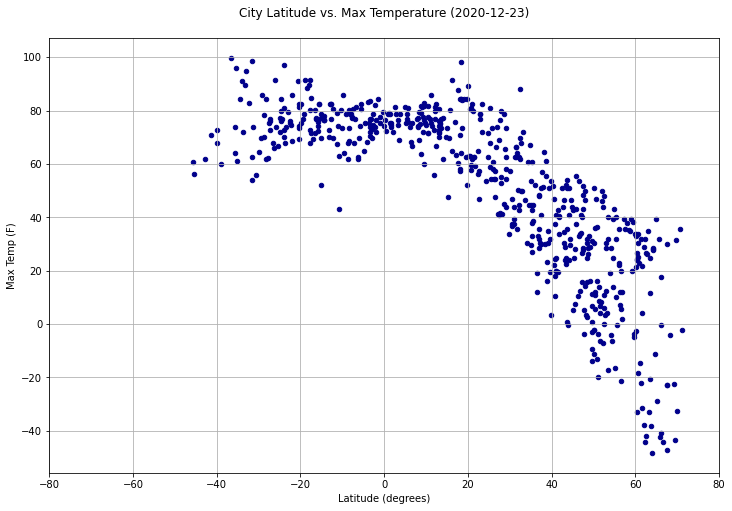

In [62]:
ax1 = dfx.plot.scatter(x='Actual Lats',
                      y='Max Temp (F)',
                      title=f"City Latitude vs. Max Temperature ({date.today()})\n",
                      grid=True, 
                      c='DarkBlue',
                      figsize=(12,8))

# Set the x scale because otherwise it goes into weird negative numbers
ax1.set_xlim((-80, 80))

# Set the x-axis label
ax1.set_xlabel("Latitude (degrees)")

plt.savefig("Fig1.png") 

## Latitude vs. Humidity Plot

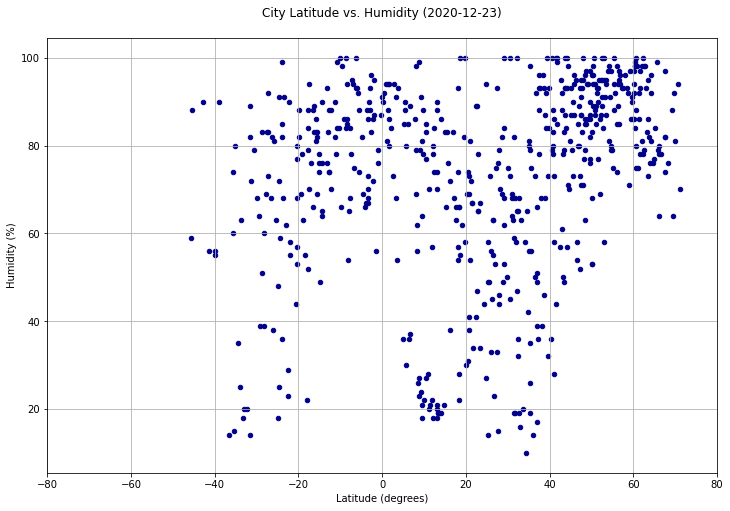

In [63]:
ax2 = dfx.plot.scatter(x='Actual Lats',
                      y='Humidity (%)',
                      title=f"City Latitude vs. Humidity ({date.today()})\n",
                      grid=True, 
                      c='DarkBlue',
                      figsize=(12,8))

# Set the x scale because otherwise it goes into weird negative numbers
ax2.set_xlim((-80, 80))

# Set the x-axis label
ax2.set_xlabel("Latitude (degrees)")

plt.savefig("Fig2.png") 

## Latitude vs. Cloudiness Plot

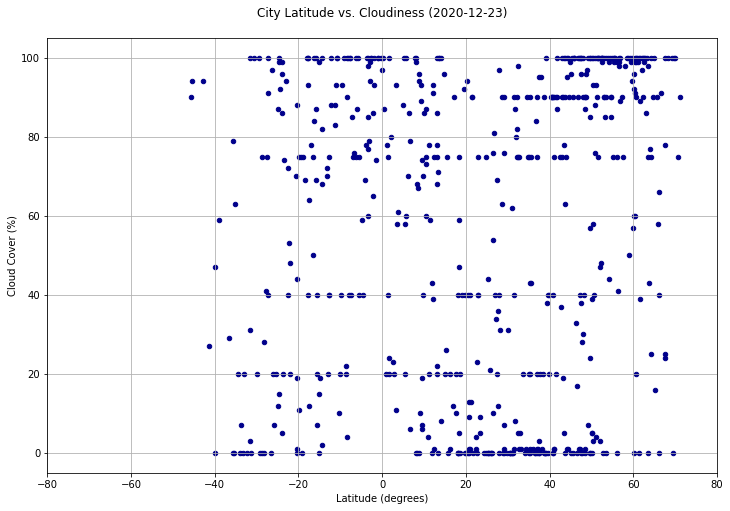

In [64]:
ax3 = dfx.plot.scatter(x='Actual Lats',
                      y='Cloud Cover (%)',
                      title=f"City Latitude vs. Cloudiness ({date.today()})\n",
                      grid=True, 
                      c='DarkBlue',
                      figsize=(12,8))

# Set the x scale because otherwise it goes into weird negative numbers
ax3.set_xlim((-80, 80))

# Set the x-axis label
ax3.set_xlabel("Latitude (degrees)")

plt.savefig("Fig3.png") 

## Latitude vs. Wind Speed Plot

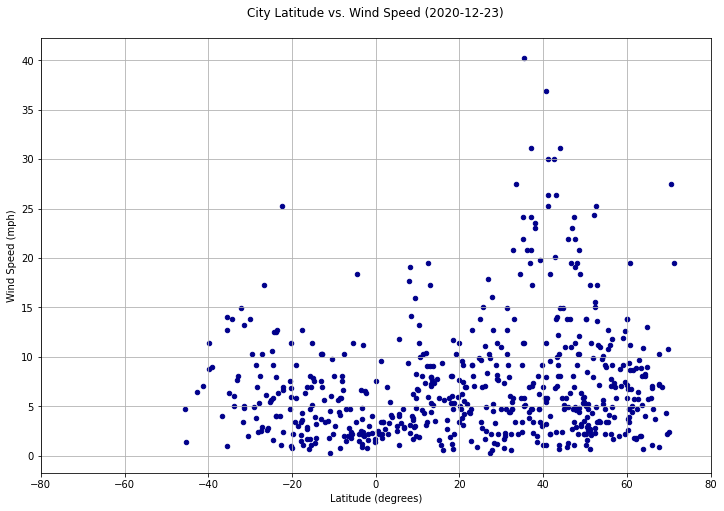

In [65]:
ax4 = dfx.plot.scatter(x='Actual Lats',
                      y='Wind Speed (mph)',
                      title=f"City Latitude vs. Wind Speed ({date.today()})\n",
                      grid=True, 
                      c='DarkBlue',
                      figsize=(12,8))

# Set the x scale because otherwise it goes into weird negative numbers
ax4.set_xlim((-80, 80))

# Set the x-axis label
ax4.set_xlabel("Latitude (degrees)")

plt.savefig("Fig4.png") 

## Linear Regression

### Regression formula explanation
![Trigonometry Explanation](../Images/slopegraphlabel2.jpg)

####  Calculate Regression Line Coordinates - Northern Hemisphere

In [44]:
# Northern Hemisphere - Max Temperature vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfn['Actual Lats'],dfn['Max Temp (F)'],1)
f = np.poly1d(d)
dfn.insert(15,'TLregr',f(dfn['Actual Lats']))

# Calculate regression formula
TLn_m = d[0]
TLn_b = d[1]
TLn_rl = f"y = {round(TLn_m, 1)}x + {round(TLn_b, 1)}"
print(TLn_rl)

y = -1.4x + 91.7


In [45]:
# Northern Hemisphere - Humidity vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfn['Actual Lats'],dfn['Humidity (%)'],1)
f = np.poly1d(d)
dfn.insert(16,'HLregr',f(dfn['Actual Lats']))

# Calculate regression formula
HLn_m = d[0]
HLn_b = d[1]
HLn_rl = f"y = {round(HLn_m, 1)}x + {round(HLn_b, 1)}"
print(HLn_rl)

y = 0.5x + 52.9


In [46]:
# Northern Hemisphere - Cloudiness vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfn['Actual Lats'],dfn['Cloud Cover (%)'],1)
f = np.poly1d(d)
dfn.insert(17,'CLregr',f(dfn['Actual Lats']))

# Calculate regression formula
CLn_m = d[0]
CLn_b = d[1]
CLn_rl = f"y = {round(CLn_m, 1)}x + {round(CLn_b, 1)}"
print(CLn_rl)

y = 0.6x + 33.5


In [47]:
# Northern Hemisphere - Wind Speed vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfn['Actual Lats'],dfn['Wind Speed (mph)'],1)
f = np.poly1d(d)
dfn.insert(18,'WLregr',f(dfn['Actual Lats']))

# Calculate regression formula
WLn_m = d[0]
WLn_b = d[1]
WLn_rl = f"y = {round(WLn_m, 1)}x + {round(WLn_b, 1)}"
print(WLn_rl)

y = 0.0x + 6.5


In [48]:
dfn.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs,Distance (mi),Max Temp (F),Humidity (%),Cloud Cover (%),Wind Speed (mph),Timestamp,Date,Hemisphere,TLregr,HLregr,CLregr,WLregr
0,"novyy urengoy, ru",novyy urengoy,ru,66.562799,77.525115,66.095686,76.656352,32.274692,-41.06,80,66,7.05,1608760273,2020-12-23 21:51:13,Northern,0.429208,88.352907,71.370420,8.878922
1,"tilhar, in",tilhar,in,27.887681,79.616505,27.961879,79.737094,5.126657,52.68,44,0,5.21,1608760274,2020-12-23 21:51:14,Northern,53.079428,67.897047,49.529999,7.512697
2,"mayo, ca",mayo,ca,64.080154,-132.471621,63.594262,-135.896492,33.572270,24.80,73,75,8.05,1608760275,2020-12-23 21:51:15,Northern,3.882850,87.011085,69.937776,8.789304
3,"awjilah, ly",awjilah,ly,29.639055,21.542582,29.090585,21.332197,37.896038,54.34,68,0,7.72,1608760276,2020-12-23 21:51:16,Northern,51.521057,68.502511,50.176444,7.553136
4,"lake havasu city, us",lake havasu city,us,34.247811,-114.375979,34.483901,-114.322455,16.312433,60.80,10,1,18.34,1608760277,2020-12-23 21:51:17,Northern,44.074665,71.395611,53.265364,7.746363


####  Calculate Regression Line Coordinates - Southern Hemisphere

In [49]:
# Southern Hemisphere - Max Temperature vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfs['Actual Lats'],dfs['Max Temp (F)'],1)
f = np.poly1d(d)
dfs.insert(15,'TLregr',f(dfs['Actual Lats']))

# Calculate regression formula
TLs_m = d[0]
TLs_b = d[1]
TLs_rl = f"y = {round(TLs_m, 1)}x + {round(TLs_b, 1)}"
print(TLs_rl)

y = 0.0x + 75.9


In [50]:
# Southern Hemisphere - Humidity vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfs['Actual Lats'],dfs['Humidity (%)'],1)
f = np.poly1d(d)
dfs.insert(16,'HLregr',f(dfs['Actual Lats']))

# Calculate regression formula
HLs_m = d[0]
HLs_b = d[1]
HLs_rl = f"y = {round(HLs_m, 1)}x + {round(HLs_b, 1)}"
print(HLs_rl)

y = 0.8x + 86.6


In [51]:
# Southern Hemisphere - Cloudiness vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfs['Actual Lats'],dfs['Cloud Cover (%)'],1)
f = np.poly1d(d)
dfs.insert(17,'CLregr',f(dfs['Actual Lats']))

# Calculate regression formula
CLs_m = d[0]
CLs_b = d[1]
CLs_rl = f"y = {round(CLs_m, 1)}x + {round(CLs_b, 1)}"
print(CLs_rl)

y = 1.2x + 82.1


In [52]:
# Southern Hemisphere - Wind Speed vs. Latitude Linear Regression
# The polyfit function from numpy performs a least squares polynomial fit over the data that it is given. 
# We want a linear regression over the data in columns Yr and Tmax so we pass these as parameters. 
# The final parameter is the degree of the polynomial. For linear regression the degree is 1.
# Calculate y-axis coordinates and insert as column TLregr (North Hemisphere Temperature v Latitutde regression line)

d = np.polyfit(dfs['Actual Lats'],dfs['Wind Speed (mph)'],1)
f = np.poly1d(d)
dfs.insert(18,'WLregr',f(dfs['Actual Lats']))

# Calculate regression formula
WLs_m = d[0]
WLs_b = d[1]
WLs_rl = f"y = {round(WLs_m, 1)}x + {round(WLs_b, 1)}"
print(WLs_rl)

y = -0.1x + 3.7


In [53]:
dfs.head()

,City-Country,City,Country,Search Lats,Search Lngs,Actual Lats,Actual Lngs,Distance (mi),Max Temp (F),Humidity (%),Cloud Cover (%),Wind Speed (mph),Timestamp,Date,Hemisphere,TLregr,HLregr,CLregr,WLregr
10,"kabalo, cd",kabalo,cd,-5.931942,26.749055,-6.032966,26.926367,6.980211,69.85,93,87,2.42,1608760285,2020-12-23 21:51:25,Southern,75.728352,81.554378,74.647806,4.378274
12,"porto belo, br",porto belo,br,-27.326495,-47.292112,-27.157394,-48.575666,11.683911,77.00,73,40,10.29,1608760287,2020-12-23 21:51:27,Southern,74.992076,63.965431,48.406179,6.659856
13,"nhulunbuy, au",nhulunbuy,au,-11.657852,138.551568,-12.182500,136.781944,36.250072,80.60,88,100,3.44,1608760288,2020-12-23 21:51:28,Southern,75.514015,76.434059,67.008604,5.042465
15,"manakara, mg",manakara,mg,-22.426125,47.837861,-22.143229,48.005982,19.546454,74.62,90,53,6.67,1608760290,2020-12-23 21:51:30,Southern,75.166841,68.140403,54.634980,6.118292
20,"nueve de julio, ar",nueve de julio,ar,-35.391369,-61.083072,-35.443907,-60.884553,3.630075,95.95,15,0,12.75,1608760298,2020-12-23 21:51:38,Southern,74.703256,57.065786,38.112334,7.554856


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

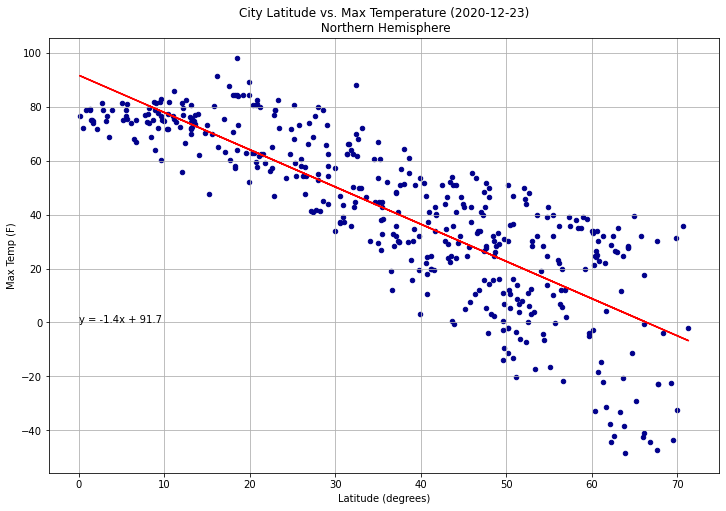

In [66]:
a = f"legend={TLn_rl}"

# Plot scatter
ax = dfn.plot.scatter(x='Actual Lats',
                      y='Max Temp (F)',
                      title=f"City Latitude vs. Max Temperature ({date.today()})\n Northern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfn.plot(x='Actual Lats', y='TLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{TLn_rl}', xy= (0, 0))

plt.savefig("Fig1-A.png") 

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

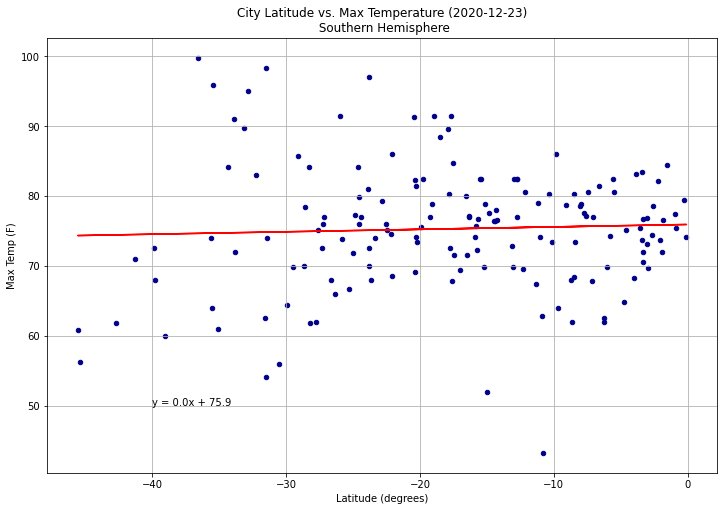

In [74]:
# Plot scatter
ax = dfs.plot.scatter(x='Actual Lats',
                      y='Max Temp (F)',
                      title=f"City Latitude vs. Max Temperature ({date.today()})\n Southern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfs.plot(x='Actual Lats', y='TLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{TLs_rl}', xy= (-40, 50))

plt.savefig("Fig1-B.png") 

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

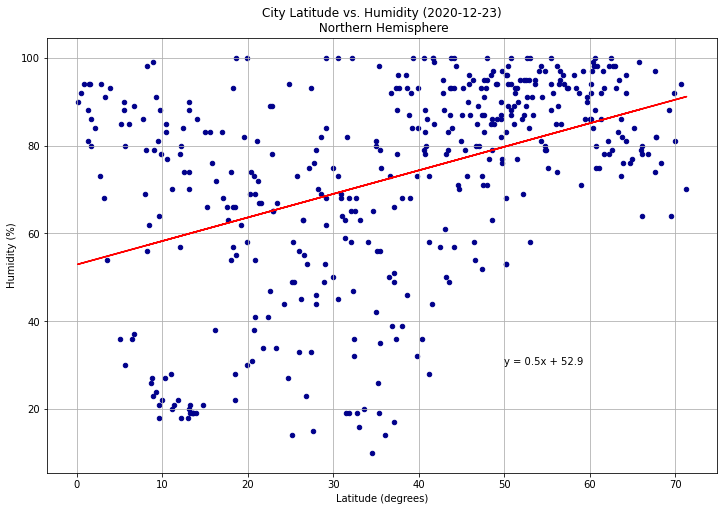

In [68]:
# Plot scatter
ax = dfn.plot.scatter(x='Actual Lats',
                      y='Humidity (%)',
                      title=f"City Latitude vs. Humidity ({date.today()})\n Northern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfn.plot(x='Actual Lats', y='HLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{HLn_rl}', xy= (50, 30))

plt.savefig("Fig2-A.png") 

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

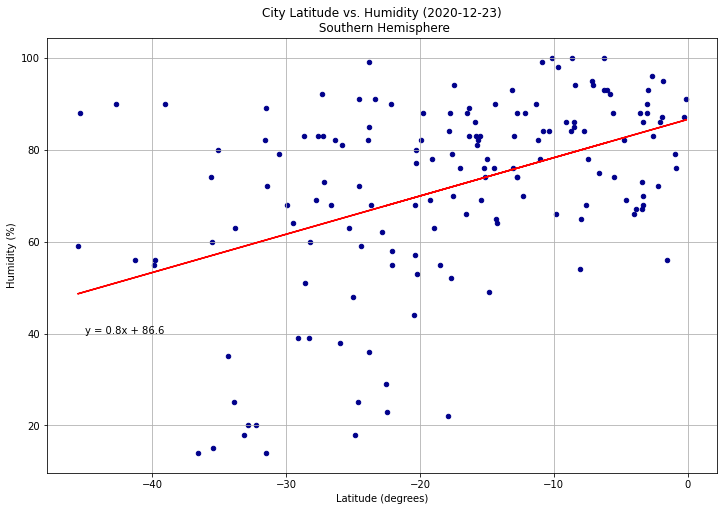

In [69]:
# Plot scatter
ax = dfs.plot.scatter(x='Actual Lats',
                      y='Humidity (%)',
                      title=f"City Latitude vs. Humidity ({date.today()})\n Southern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfs.plot(x='Actual Lats', y='HLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{HLs_rl}', xy= (-45, 40))

plt.savefig("Fig2-B.png") 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

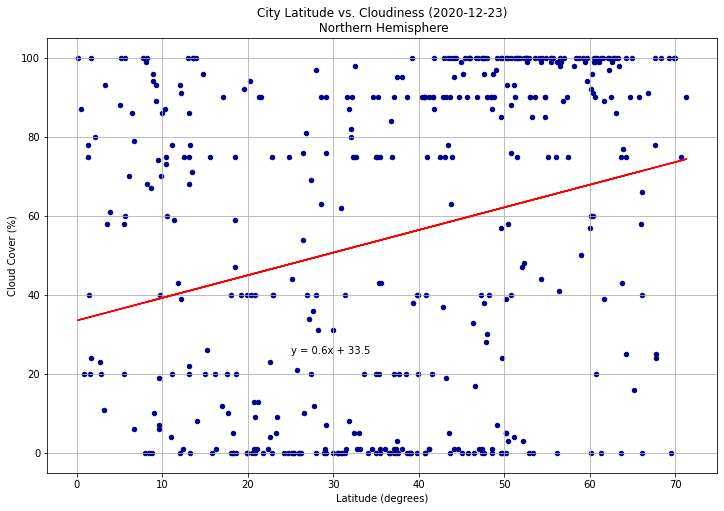

In [70]:
# Plot scatter
ax = dfn.plot.scatter(x='Actual Lats',
                      y='Cloud Cover (%)',
                      title=f"City Latitude vs. Cloudiness ({date.today()})\n Northern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfn.plot(x='Actual Lats', y='CLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{CLn_rl}', xy= (25, 25))

plt.savefig("Fig3-A.png") 

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

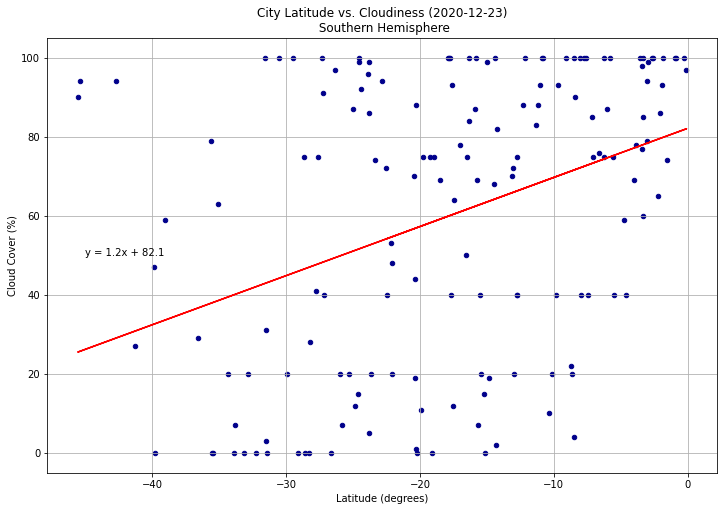

In [71]:
# Plot scatter
ax = dfs.plot.scatter(x='Actual Lats',
                      y='Cloud Cover (%)',
                      title=f"City Latitude vs. Cloudiness ({date.today()})\n Southern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfs.plot(x='Actual Lats', y='CLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{CLs_rl}', xy= (-45, 50))

plt.savefig("Fig3-B.png") 

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

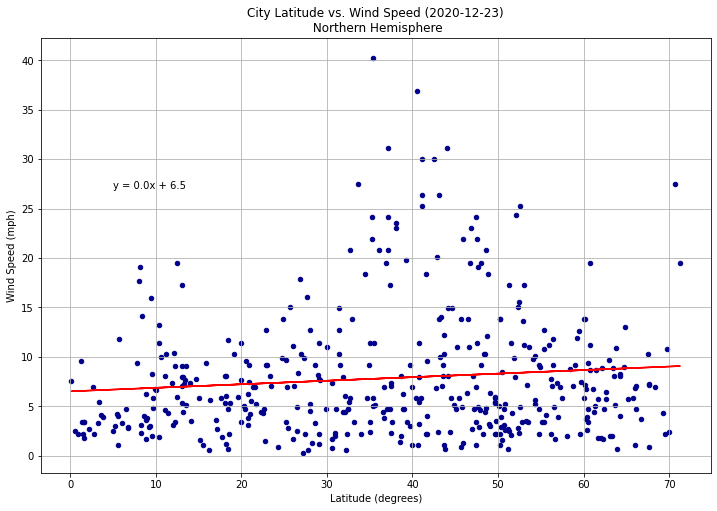

In [72]:
# Plot scatter
ax = dfn.plot.scatter(x='Actual Lats',
                      y='Wind Speed (mph)',
                      title=f"City Latitude vs. Wind Speed ({date.today()})\n Northern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfn.plot(x='Actual Lats', y='WLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{WLn_rl}', xy= (5, 27))

plt.savefig("Fig4-A.png") 

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

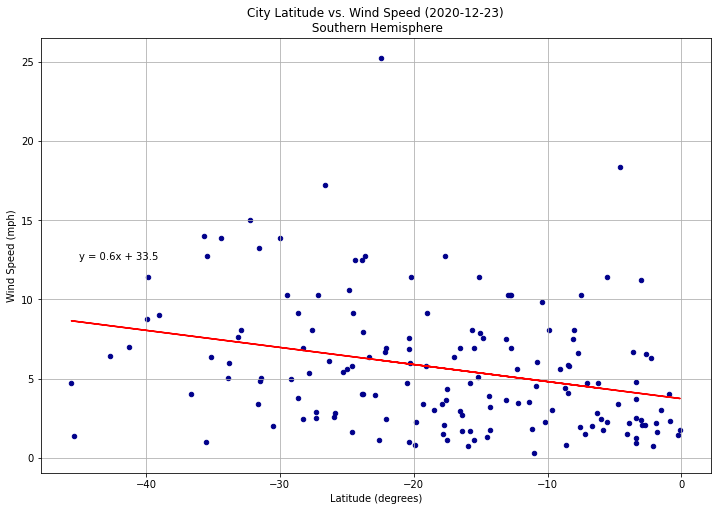

In [73]:
# Plot scatter
ax = dfs.plot.scatter(x='Actual Lats',
                      y='Wind Speed (mph)',
                      title=f"City Latitude vs. Wind Speed ({date.today()})\n Southern Hemisphere",
                      c='DarkBlue',
                      figsize=(12,8))

# Plot regression line, with a grid, omitting legend (important)
dfs.plot(x='Actual Lats', y='WLregr', color='Red', legend=False, grid=True, ax=ax)

# Set the x-axis label and regression line formula as annotation
ax.set_xlabel("Latitude (degrees)")
ax.annotate(f'{CLn_rl}', xy= (-45, 12.5))

plt.savefig("Fig4-B.png") 